# Evaluation

In [245]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from nltk.metrics import f_measure, precision, accuracy
import nltk
#nltk.download('punkt')

import torch
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
from transformers import QuestionAnsweringPipeline

sns.set_palette(palette='Paired')
sns.set_style('whitegrid')

In [246]:
# Albert
albert_tokenizer = AutoTokenizer.from_pretrained("Firat/albert-base-v2-finetuned-squad")
albert = AutoModelForQuestionAnswering.from_pretrained("Firat/albert-base-v2-finetuned-squad")

In [247]:
# Roberta
roberta_tokenizer = AutoTokenizer.from_pretrained("Firat/roberta-base-finetuned-squad")
roberta = AutoModelForQuestionAnswering.from_pretrained("Firat/roberta-base-finetuned-squad")

In [423]:
# Distilbert
distilbert_tokenizer = AutoTokenizer.from_pretrained("Firat/distilbert-base-uncased-finetuned-squad")
distilbert = AutoModelForQuestionAnswering.from_pretrained("Firat/distilbert-base-uncased-finetuned-squad")

In [249]:
# Load Questions
data = pd.read_excel('question_collection.xlsx')
data.columns = [col.lower() for col in data.columns]
data.head(2)

,id,topic,difficulty (1-3),text,question 1,answer 1,question 2,answer 2,question 3,answer 3
0,1.0,history,1.0,"World War II or the Second World War, often ab...",When took the second World War place?,1939 to 1945,How many personnel was involved?,more than 100 million,Who were the majority of fatalities?,civilians
1,2.0,health,3.0,Occupational therapy (OT) is a profession with...,Occupational therapy is profession within whic...,healthcare,By who is it performed?,occupational therapists and occupational thera...,What are common occupational therapy inerventi...,"helping children with disabilities, injury reh..."


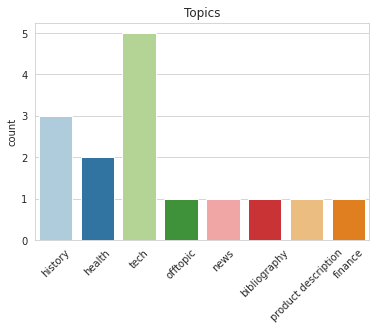

In [250]:
p = sns.countplot(x=data['topic'])
p.set_xticklabels(labels=p.get_xticklabels() , rotation=45)
p.set_xlabel('')
p.set_title('Topics')
plt.show()

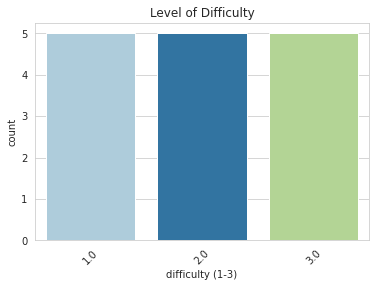

In [251]:
p = sns.countplot(x=data['difficulty (1-3)'])
p.set_xticklabels(labels=p.get_xticklabels() , rotation=45)
p.set_title('Level of Difficulty')
plt.show()

In [252]:
text = data.loc[0, 'text']
q1 = data.loc[0, 'question 1']
q2 = data.loc[0, 'question 2']
q3 = data.loc[0, 'question 3']
print(text)
print(40*'=')
print(q1)
print(40*'=')
print(q2)
print(40*'=')
print(q3)

World War II or the Second World War, often abbreviated as WWII or WW2, was a global war that lasted from 1939 to 1945. It involved the vast majority of the world's countries—including all of the great powers—forming two opposing military alliances: the Allies and the Axis powers. In a total war directly involving more than 100 million personnel from more than 30 countries, the major participants threw their entire economic, industrial, and scientific capabilities behind the war effort, blurring the distinction between civilian and military resources. Aircraft played a major role in the conflict, enabling the strategic bombing of population centres and the only two uses of nuclear weapons in war. World War II was by far the deadliest conflict in human history; it resulted in 70 to 85 million fatalities, a majority being civilians. Tens of millions of people died due to genocides (including the Holocaust), starvation, massacres, and disease. In the wake of the Axis defeat, Germany and J

In [253]:
foo = np.array(roberta_tokenizer(q1, padding='max_length')['input_ids'])
print(foo[foo != 1].shape)
print(len(q1.split(' ')))

(10,)
7


Jedes Wort bildet ein Token mit Start und End-Token. Es werden auch Satzzeichen tokenisiert.

In [254]:
inputs = roberta_tokenizer(text, padding="max_length", truncation=True)
print(inputs)

{'input_ids': [0, 10988, 1771, 3082, 50, 5, 4665, 623, 1771, 6, 747, 40993, 1070, 25, 29001, 50, 15584, 176, 6, 21, 10, 720, 997, 14, 9200, 31, 28234, 7, 21123, 4, 85, 963, 5, 4714, 1647, 9, 5, 232, 18, 749, 578, 8529, 70, 9, 5, 372, 4361, 578, 11847, 80, 9375, 831, 22484, 35, 5, 37761, 8, 5, 34073, 4361, 4, 96, 10, 746, 997, 2024, 3329, 55, 87, 727, 153, 3775, 31, 55, 87, 389, 749, 6, 5, 538, 3597, 4021, 49, 1445, 776, 6, 2683, 6, 8, 6441, 5587, 639, 5, 997, 1351, 6, 3089, 16715, 5, 16192, 227, 8233, 8, 831, 1915, 4, 25221, 702, 10, 538, 774, 11, 5, 3050, 6, 10298, 5, 3461, 10183, 9, 1956, 7872, 8, 5, 129, 80, 2939, 9, 1748, 2398, 11, 997, 4, 623, 1771, 3082, 21, 30, 444, 5, 16751, 3050, 11, 1050, 750, 131, 24, 4596, 11, 1510, 7, 5663, 153, 16982, 6, 10, 1647, 145, 6321, 4, 29031, 9, 2535, 9, 82, 962, 528, 7, 12358, 1975, 4376, 36, 8529, 5, 13903, 238, 31536, 6, 39246, 6, 8, 2199, 4, 96, 5, 3874, 9, 5, 34073, 3002, 6, 1600, 8, 1429, 58, 9533, 6, 8, 997, 3474, 28406, 879, 1536, 58, 296

Das Dictionary besteht aus den encodeten ID's und aus den Attention Mask. Die Attention Mask bezieht sich eigentlich nur auf den Wortteil, welcher nicht gepadded wurde. Das Padding wurde beim Tokenizer  mit dem Token 1 implementiert..

In [255]:
print([(i, roberta_tokenizer.convert_ids_to_tokens(i)) for i in range(4)])

[(0, '<s>'), (1, '<pad>'), (2, '</s>'), (3, '<unk>')]


Die oberen Token stellen besondere Token dar wie start_token als 1, pad_token als 1, 2 als end_token und einen unbekannten Token mit der ID 3.

In [256]:
att = np.array(inputs['attention_mask'])
att

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [257]:
# Extraction of topk: topk=10
roberta_pipeline = QuestionAnsweringPipeline(model=roberta, tokenizer=roberta_tokenizer, top_k=2)

In [258]:
text_id = 3
print(data.loc[text_id, 'question 1'])
print(roberta_pipeline(question=data.loc[text_id, 'question 1'], context=data.loc[text_id, 'text']))
print(data.loc[text_id, 'answer 1'])

On who focuses the series?
[{'score': 0.9776242971420288, 'start': 22, 'end': 37, 'answer': 'Monkey D. Luffy'}, {'score': 0.014314273372292519, 'start': 22, 'end': 38, 'answer': 'Monkey D. Luffy,'}]
Monkey D. Ruffy


In [406]:
from nltk.tokenize import word_tokenize

class QAEvaluate(object):
    """

    """
    
    
    def __init__(self, model, tokenizer, top_k=1, return_answer_only=True, 
                 metric='F1', evaluate_tokenized=True):
        """
        
        """
        self.model = model
        self.tokenizer = tokenizer
        self.pipeline = QuestionAnsweringPipeline(model=model, 
                                                  tokenizer=tokenizer, 
                                                  top_k=top_k)
        self.return_answer_only = return_answer_only
        self.metric = metric
        self.evaluate_tokenized = evaluate_tokenized
        
    def answer_all(self, texts: np.ndarray, questions: np.ndarray):
        answers = {}
        # Answer all Questions
        with tqdm(total=len(texts)*len(questions[0]), desc='Answering Questions') as pbar:
            for i, text in enumerate(texts):
                answers[i] = {}
                for j, question in enumerate(questions[i]):
                    answer = self.answer_question(question=question, text=text)
                    answers[i][j] = answer
                    pbar.update(1)
        
        return answers
    
    def evaluate(self, texts: np.ndarray, questions: np.ndarray, reference_answers: np.ndarray):
        """"""
        # Call function to answer all by system
        answers = self.answer_all(texts=texts, questions=questions) 
        
        # Evaluate all questions    
        # Prepare answers as array
        answers = self._convert_to_array(answers)
        scores = self._calculate_scores(reference=reference_answers, test=answers)
        
        return scores
    
    def answer_question(self, question, text):
        """"""
        # Return answer from model
        answer = self.pipeline(question=question, context=text)
        
        if self.return_answer_only:
            answer = answer['answer']
        
        return dict(question=question, answer=answer)

            
    @staticmethod
    def _convert_to_array(A):
        """"""
        answers = []
        for i, text in A.items():
            question_answers = []
            for j, qa in text.items():
                question_answers.append(qa['answer'])
            answers.append(question_answers)
            
        return np.array(answers, dtype=str)
    
    def _calculate_scores(self, reference, test):
        """"""
        if self.metric == 'F1':
            metric_func = f_measure
        elif self.metric == 'precision':
            metric_func = precision
        else:
            raise Exception('Metric does not fitted supported Functions within this class: [F1, accuracy, precision]')
            
        scores = self.__calculate_metric(metric_func=metric_func, reference=reference, 
                                         test=test, tokenized=self.evaluate_tokenized)
        
        return scores
        
    @staticmethod
    def __calculate_metric(metric_func, reference, test, tokenized=True):
        """"""
        assert reference.shape == test.shape 
        
        scores = np.empty(shape=reference.shape)
        for i in tqdm(range(reference.shape[0]), desc='Calculating Scores'):
            for j in range(reference.shape[1]):
                if tokenized:
                    # Tokenize Words
                    t, ref = set(word_tokenize(str(test[i, j]))), set(word_tokenize(str(reference[i, j])))
                else:
                    t, ref = set([test[i, j]]), set([reference[i, j]])
                # Score
                score = metric_func(reference=ref, test=t)
                scores[i, j] = score
                
        return scores

In [407]:
evaluator = QAEvaluate(model=roberta, tokenizer=roberta_tokenizer)

In [408]:
data.loc[0, 'question 1']

'When took the second World War place?'

In [409]:
evaluator.answer_question(question=data.loc[0, 'question 1'], text=data.loc[0, 'text'])

{'question': 'When took the second World War place?', 'answer': '1945'}

In [410]:
select_n = 3
texts = data.loc[:select_n, 'text'].to_list()
questions = data.loc[:select_n, ['question 1', 'question 2', 'question 3']].to_numpy()
reference_answers = data.loc[:select_n, ['answer 1', 'answer 2', 'answer 3']].to_numpy()

In [411]:
questions_answers = evaluator.answer_all(texts=texts, questions=questions)
questions_answers[0]

Answering Questions:   0%|          | 0/12 [00:00<?, ?it/s]

{0: {'question': 'When took the second World War place?', 'answer': '1945'},
 1: {'question': 'How many personnel was involved?',
  'answer': 'more than 100 million'},
 2: {'question': 'Who were the majority of fatalities?',
  'answer': 'civilians'}}

----

In [412]:
texts = data.loc[:, 'text'].to_list()
questions = data.loc[:, ['question 1', 'question 2', 'question 3']].to_numpy()
reference_answers = data.loc[:, ['answer 1', 'answer 2', 'answer 3']].to_numpy()
print(questions.shape)

(15, 3)


In [422]:
evaluator = QAEvaluate(model=roberta, tokenizer=roberta_tokenizer, top_k=1, 
                       return_answer_only=True, metric='F1', evaluate_tokenized=True)
roberta_scores = evaluator.evaluate(texts=texts, questions=questions, 
                            reference_answers=reference_answers)

Answering Questions:   0%|          | 0/45 [00:00<?, ?it/s]

Calculating Scores:   0%|          | 0/15 [00:00<?, ?it/s]

In [424]:
evaluator = QAEvaluate(model=distilbert, tokenizer=distilbert_tokenizer, top_k=1, 
                       return_answer_only=True, metric='F1', evaluate_tokenized=True)
distilbert_scores = evaluator.evaluate(texts=texts, questions=questions, 
                            reference_answers=reference_answers)

Answering Questions:   0%|          | 0/45 [00:00<?, ?it/s]

Calculating Scores:   0%|          | 0/15 [00:00<?, ?it/s]

In [425]:
evaluator = QAEvaluate(model=albert, tokenizer=albert_tokenizer, top_k=1, 
                       return_answer_only=True, metric='F1', evaluate_tokenized=True)
albert_scores = evaluator.evaluate(texts=texts, questions=questions, 
                            reference_answers=reference_answers)

Answering Questions:   0%|          | 0/45 [00:00<?, ?it/s]

Calculating Scores:   0%|          | 0/15 [00:00<?, ?it/s]

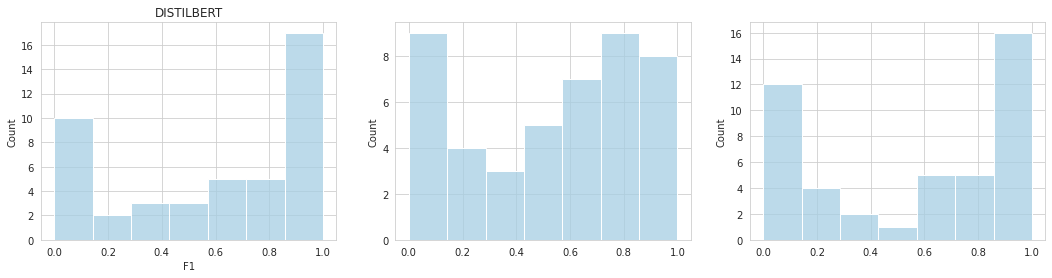

In [429]:
fig = plt.subplots(figsize=(18, 4))

plt.subplot(1,3,1)
p = sns.histplot(roberta_scores.flatten())
p.set_title('ROBERTA')
p.set_xlabel('F1')

plt.subplot(1,3,2)
sns.histplot(albert_scores.flatten())
p.set_title('ALBERT')
p.set_xlabel('F1')

plt.subplot(1,3,3)
sns.histplot(distilbert_scores.flatten())
p.set_title('DISTILBERT')
p.set_xlabel('F1')

plt.show()

In [419]:
np.mean(scores)

0.5944690012588693

In [450]:
data.head(5)

,id,topic,difficulty (1-3),text,question 1,answer 1,question 2,answer 2,question 3,answer 3
0,1.0,history,1.0,"World War II or the Second World War, often ab...",When took the second World War place?,1939 to 1945,How many personnel was involved?,more than 100 million,Who were the majority of fatalities?,civilians
1,2.0,health,3.0,Occupational therapy (OT) is a profession with...,Occupational therapy is profession within whic...,healthcare,By who is it performed?,occupational therapists and occupational thera...,What are common occupational therapy inerventi...,"helping children with disabilities, injury reh..."
2,3.0,tech,2.0,"In deep learning, each level learns to transfo...",What can a raw input may be?,a matrix of pixels,What does the second layer?,compose and encode arrangements,What network is it about?,None
3,4.0,offtopic,1.0,"The series focuses on Monkey D. Luffy, a young...",On who focuses the series?,Monkey D. Ruffy,What is the name of the pirate crew?,Straw Hat Pirates,How is the mythical treasure called?,One Piece
4,5.0,news,2.0,He told a news conference Mr Putin would pay a...,What would Putin pay for invading?,serious and dear price,Who warned that the comments could further des...,The Kremlin,How many troops are near of the border?,100.0


In [451]:
texts = data.loc[2, 'text']
questions = data.loc[2, ['question 1', 'question 2', 'question 3']].to_numpy()
reference_answers = data.loc[2, ['answer 1', 'answer 2', 'answer 3']].to_numpy()

In [452]:
texts

'In deep learning, each level learns to transform its input data into a slightly more abstract and composite representation. In an image recognition application, the raw input may be a matrix of pixels; the first representational layer may abstract the pixels and encode edges; the second layer may compose and encode arrangements of edges; the third layer may encode a nose and eyes; and the fourth layer may recognize that the image contains a face. Importantly, a deep learning process can learn which features to optimally place in which level on its own. This does not completely eliminate the need for hand-tuning; for example, varying numbers of layers and layer sizes can provide different degrees of abstraction.'

In [456]:
evaluator_roberta = QAEvaluate(model=roberta, tokenizer=roberta_tokenizer, return_answer_only=False)
evaluator_distilbet = QAEvaluate(model=distilbert, tokenizer=distilbert_tokenizer, return_answer_only=False)
evaluator_albert = QAEvaluate(model=albert, tokenizer=albert_tokenizer, return_answer_only=False)

In [454]:
questions[0]

'What can a raw input may be?'

In [457]:
evaluator_roberta.answer_question(questions[2], texts)

{'question': 'What network is it about?',
 'answer': {'score': 0.058430835604667664,
  'start': 3,
  'end': 16,
  'answer': 'deep learning'}}

In [458]:
evaluator_albert.answer_question(questions[2], texts)

{'question': 'What network is it about?',
 'answer': {'score': 0.011551029980182648,
  'start': 3,
  'end': 17,
  'answer': 'deep learning,'}}

In [459]:
evaluator_distilbet.answer_question(questions[2], texts)

{'question': 'What network is it about?',
 'answer': {'score': 0.18043021857738495,
  'start': 130,
  'end': 159,
  'answer': 'image recognition application'}}